# Earnings Announcement Event Study: Data Preparation
This notebook prepares stock return data, earnings dates, and market index data for an event study. It constructs event, buffer, and estimation windows and calculates market-adjusted abnormal returns.

### Event Study Methodology Overview

This analysis uses a standard event study framework to measure how stock prices react to earnings announcements. Rather than looking at raw returns around earnings dates, we first estimate how each stock normally moves in relation to the overall market. This is done using a “market model,” where historical stock returns are regressed on market returns during a pre-event estimation window.

Using the estimated relationship, we then calculate the return we would expect to observe in the absence of any special event. The difference between the actual return and this expected return is the abnormal return (AR), which represents the portion of price movement not explained by general market conditions. Abnormal returns are calculated for each day in the event window surrounding earnings announcements, and summed to produce cumulative abnormal returns (CAR), which capture the total unexpected price impact of the earnings event.

This approach allows us to isolate the market’s reaction to earnings news from broader market movements, providing a clearer measure of how firm-specific information affects stock prices.

## 1. Imports and settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm
from scipy import stats

### Parameters (time filter)

In [2]:
# Disable this if you want to work with the full dataset (2005-2025).
START_DATE = pd.Timestamp("2022-01-01")
END_DATE   = pd.Timestamp("2025-12-31")

## 2. Load data

In [3]:
# Load stock price and earnings data.
panel = pd.read_csv("event_study_price_data.csv")

# Load nasdaq composite index levels.
nasdaq = pd.read_csv("nasdaq_composite_index.csv")

# Keep "full" copies of datasets
panel_full = panel.copy()
nasdaq_full = nasdaq.copy()

## 3. Prepare market returns (NASDAQ)

In [4]:
nasdaq.head()

,date,nasdaq_close
0,2005/01/03,2152.15
1,2005/01/04,2107.86
2,2005/01/05,2091.24
3,2005/01/06,2090.00
4,2005/01/07,2088.61


In [5]:
# Convert NASDAQ date column to datetime.
nasdaq["date"] = pd.to_datetime(nasdaq["date"])

# Sort by date to ensure correct return calculation.
nasdaq = nasdaq.sort_values("date")

# Calculate daily market return from NASDAQ index level.
nasdaq["market_return"] = nasdaq["nasdaq_close"].pct_change(fill_method=None)

# Create a percentage version for readability (note: all modelling uses decimal returns).
nasdaq["market_return_pct"] = nasdaq["market_return"] * 100

nasdaq.head()

,date,nasdaq_close,market_return,market_return_pct
0,2005-01-03,2152.15,NaN,NaN
1,2005-01-04,2107.86,-0.020579,-2.057942
2,2005-01-05,2091.24,-0.007885,-0.788477
3,2005-01-06,2090.00,-0.000593,-0.059295
4,2005-01-07,2088.61,-0.000665,-0.066507


In [6]:
nasdaq["market_return_pct"].describe()

count    5305.000000
mean        0.054213
std         1.365580
min       -12.321331
25%        -0.522449
50%         0.106969
75%         0.719197
max        12.163158
Name: market_return_pct, dtype: float64

#### Interpretation of NASDAQ daily returns
The average daily return of approximately 0.05% corresponds to roughly 13–14% per year (assuming ~252 trading days). The standard deviation of about 1.4% reflects typical daily market volatility.The extreme values (−12% and +12%) correspond to major crisis-era market moves.

## 4. Prepare stock returns and base panel

In [7]:
panel.head()

,ticker,date,open,high,low,close,volume,earnings_date,td_num,event_day,daily_return,daily_return_pct
0,AAPL,2005-01-03,1.16,1.16,1.12,1.13,12382431,NaN,0,NaN,NaN,NaN
1,AAPL,2005-01-04,1.14,1.17,1.12,1.14,19608238,NaN,1,NaN,0.008850,0.884956
2,AAPL,2005-01-05,1.15,1.17,1.14,1.15,12157876,NaN,2,NaN,0.008772,0.877193
3,AAPL,2005-01-06,1.16,1.16,1.13,1.15,12604964,NaN,3,NaN,0.000000,0.000000
4,AAPL,2005-01-07,1.16,1.24,1.16,1.24,39923768,NaN,4,NaN,0.078261,7.826087


In [8]:
# Convert date columns to datetime.
panel["date"] = pd.to_datetime(panel["date"])
panel["earnings_date"] = pd.to_datetime(panel["earnings_date"])

# Sort by ticker and date so returns are calculated in the correct order.
panel = panel.sort_values(["ticker", "date"])

panel["daily_return_pct"].describe()

count    15846.000000
mean         0.133842
std          2.452579
min        -31.111111
25%         -0.923480
50%          0.000000
75%          1.250586
max         30.177515
Name: daily_return_pct, dtype: float64

### Interpretation of daily returns for Apple, Google, and Nvidia
The individual stocks show much higher daily volatility than the NASDAQ index, which is expected because the index shows the performance of many companies. Large daily moves (±20–30%) likely reflect firm-specific earnings reactions and periods of market stress.

### Time filter

In [9]:
# ---- Time filter (single source of truth) ----
# We filter events to START_DATE..END_DATE
# BUT we keep extra history in the price/market data so estimation windows still work.

EST_DAYS = 180
BUFFER_DAYS = 30
EVENT_PRE = 5
EVENT_POST = 5

if START_DATE is not None and END_DATE is not None:
    data_start = START_DATE - pd.Timedelta(days=EST_DAYS + BUFFER_DAYS + EVENT_PRE + 10)
    data_end   = END_DATE   + pd.Timedelta(days=EVENT_POST + 10)

    # Filter the underlying daily data (keeps enough pre-history for estimation)
    panel = panel[(panel["date"] >= data_start) & (panel["date"] <= data_end)].copy()
    nasdaq = nasdaq[(nasdaq["date"] >= data_start) & (nasdaq["date"] <= data_end)].copy()

## 5. Build event study panel (event_id, event_day, windows)

In [10]:
# Create a table of unique earnings events (one per ticker per earnings date).
events = (
    panel.loc[panel["earnings_date"].notna(), ["ticker", "earnings_date"]]
    .drop_duplicates()
    .sort_values(["ticker", "earnings_date"])
)

# Filter events to the desired time period.
if START_DATE is not None and END_DATE is not None:
    events = events[(events["earnings_date"] >= START_DATE) & (events["earnings_date"] <= END_DATE)].copy()

# Create an event_id for each earnings announcement.
events["event_id"] = (
    events["ticker"] + "_" + events["earnings_date"].dt.strftime("%Y-%m-%d")
)

events.head()

,ticker,earnings_date,event_id
4341,AAPL,2022-03-31,AAPL_2022-03-31
4403,AAPL,2022-06-30,AAPL_2022-06-30
4467,AAPL,2022-09-30,AAPL_2022-09-30
4592,AAPL,2023-03-31,AAPL_2023-03-31
4654,AAPL,2023-06-30,AAPL_2023-06-30


In [11]:
# Expand each event into a window: For each earnings event, create a mini dataset covering days -180 to +5 around that event, 
# then stack all those mini datasets into one big table (event_panel).

# Create an empty list to store each event's mini dataset.
event_rows = []

# Loop through each earnings event (each row in the "events" DataFrame).
for _, row in events.iterrows():
    ticker = row["ticker"]
    event_date = row["earnings_date"]
    event_id = row["event_id"]

    df_ticker = panel[panel["ticker"] == ticker].copy()

    # Calculate days relative to earnings date and label each daily row accordingly.
    df_ticker["event_day"] = (df_ticker["date"] - event_date).dt.days

    # Keep only the window we care about (-180 days to +5 days).
    df_window = df_ticker[(df_ticker["event_day"] >= -180) & (df_ticker["event_day"] <= 5)].copy()

    # Label every row in the window with the event identity.
    df_window["event_id"] = event_id
    df_window["event_date"] = event_date

    # Add this event's mini dataset to the list
    event_rows.append(df_window)

# Stack all events in a single event_panel DataFrame
event_panel = pd.concat(event_rows, ignore_index=True)

event_panel[["event_id", "ticker", "date", "event_day"]].head()

,event_id,ticker,date,event_day
0,AAPL_2022-03-31,AAPL,2021-10-04,-178
1,AAPL_2022-03-31,AAPL,2021-10-05,-177
2,AAPL_2022-03-31,AAPL,2021-10-06,-176
3,AAPL_2022-03-31,AAPL,2021-10-07,-175
4,AAPL_2022-03-31,AAPL,2021-10-08,-174


In [12]:
# Label each row according to its role in the event study window structure.

conditions = [
    (event_panel["event_day"] >= -180) & (event_panel["event_day"] <= -30),
    (event_panel["event_day"] >= -29) & (event_panel["event_day"] <= -6),
    (event_panel["event_day"] >= -5) & (event_panel["event_day"] <= 5)
]

choices = ["estimation", "buffer", "event"]

event_panel["window"] = np.select(conditions, choices, default="other")

# Quick preview
event_panel[["event_id", "date", "event_day", "window"]].head(10)

,event_id,date,event_day,window
0,AAPL_2022-03-31,2021-10-04,-178,estimation
1,AAPL_2022-03-31,2021-10-05,-177,estimation
2,AAPL_2022-03-31,2021-10-06,-176,estimation
3,AAPL_2022-03-31,2021-10-07,-175,estimation
4,AAPL_2022-03-31,2021-10-08,-174,estimation
5,AAPL_2022-03-31,2021-10-11,-171,estimation
6,AAPL_2022-03-31,2021-10-12,-170,estimation
7,AAPL_2022-03-31,2021-10-13,-169,estimation
8,AAPL_2022-03-31,2021-10-14,-168,estimation
9,AAPL_2022-03-31,2021-10-15,-167,estimation


In [13]:
# Check that the time window was built correctly.
event_panel["event_day"].min(), event_panel["event_day"].max()

(-180, 5)

In [14]:
# Check window label counts.
event_panel["window"].value_counts()

window
estimation    3510
buffer         570
event          244
Name: count, dtype: int64

### Interpretation of output
The event panel spans −180 to +5 days around each earnings announcement. Most observations fall in the estimation window (used to model normal returns), with smaller portions in the buffer (to avoid contamination from information leakage) and event window (used to measure abnormal returns).

A rough back-of-the-envelope check helps confirm the structure looks reasonable. The event window covers 11 days (−5 to +5). Dividing the total number of event-window rows by 11 suggests on the order of ~100 earnings events in the sample, which is plausible given three firms over roughly two decades of quarterly announcements, allowing for missing early data and incomplete windows.

The estimation window is much larger by design (about 150 days per event), so it naturally accounts for most rows. Exact counts differ from simple multiplication because windows are defined in calendar days but only trading days appear in the data, and estimation windows for different events can overlap. This means the same real trading day can contribute to multiple events’ estimation samples, which is expected and not an error.

Overall, the distribution of rows across estimation, buffer, and event windows is consistent with the intended event study design.

## 6. Merge market returns into event panel
We add NASDAQ market returns to each event-day observation so that we can estimate expected (normal) stock returns using the market model.

In [15]:
# Merge market_return with event_panel

# Ensure date columns are datetime.
event_panel["date"] = pd.to_datetime(event_panel["date"])
nasdaq["date"] = pd.to_datetime(nasdaq["date"])

# Keep only the required columns and ensure one row per date.
nasdaq_mkt = nasdaq[["date", "market_return", "market_return_pct"]].drop_duplicates(subset=["date"])

# Merge market returns into the event panel.
event_panel = event_panel.merge(nasdaq_mkt, on="date", how="left")

# Check that market_return exists and is mostly populated.
event_panel["market_return"].isna().mean()

np.float64(0.0)

In [16]:
nasdaq.columns

Index(['date', 'nasdaq_close', 'market_return', 'market_return_pct'], dtype='object')

In [17]:
event_panel[["date", "ticker", "daily_return", "market_return", "market_return_pct"]].head()

,date,ticker,daily_return,market_return,market_return_pct
0,2021-10-04,AAPL,-0.024606,-0.021364,-2.136448
1,2021-10-05,AAPL,0.014158,0.012510,1.251027
2,2021-10-06,AAPL,0.006307,0.004717,0.471670
3,2021-10-07,AAPL,0.009085,0.010489,1.048896
4,2021-10-08,AAPL,-0.002722,-0.005083,-0.508256


## 7. Compute abnormal returns (AR) and cumulative abnormal returns (CAR)

### Illustration: Market Model for a Single Earnings Event

Before applying the market model to every earnings announcement, we first demonstrate the process for one example event. This helps illustrate how normal returns are estimated using the estimation window, and how abnormal returns are calculated during the event window. The same procedure is then repeated for all events in the dataset.

In [18]:
# Select one example event to illustrate the market model estimation.
example_event_id = event_panel["event_id"].unique()[0]
df_example = event_panel[event_panel["event_id"] == example_event_id]

# Use the estimation window to fit the market model.
est_example = df_example[df_example["window"] == "estimation"].dropna(subset=["daily_return", "market_return"])

X_ex = sm.add_constant(est_example["market_return"])
y_ex = est_example["daily_return"]

model_ex = sm.OLS(y_ex, X_ex).fit()

model_ex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     160.5
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           1.39e-22
Time:                        18:23:35   Log-Likelihood:                 324.89
No. Observations:                 103   AIC:                            -645.8
Df Residuals:                     101   BIC:                            -640.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.913      0.059   -7.32e-05       0.004
market_return     0.8673      0.068     12.667      0.000       0.731       1.003
==============================================================================
Omnibus:                       33.106   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.084
Skew:                           1.153   Prob(JB):                     5.51e-19
Kurtosis:                       6.778   Cond. No.                         66.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observations
The market model regression shows that Apple has a beta of approximately 1.5, meaning it typically moves more than the market on a daily basis. The relationship is statistically significant, and around 22% of daily return variation is explained by general market movements. This fitted relationship defines Apple’s “normal” behaviour, which is then used to calculate abnormal returns around earnings announcements.

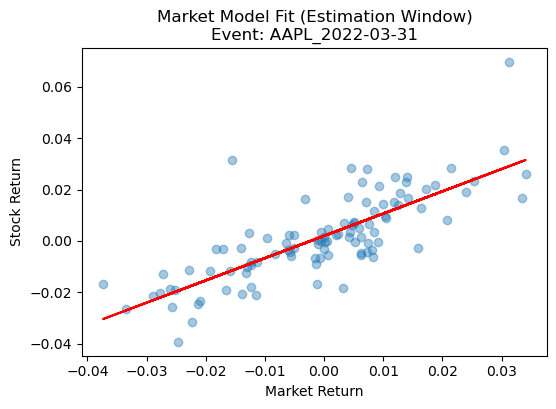

In [19]:
plt.figure(figsize=(6,4))
plt.scatter(est_example["market_return"], est_example["daily_return"], alpha=0.4)
plt.plot(est_example["market_return"],
         model_ex.predict(X_ex),
         color="red")
plt.xlabel("Market Return")
plt.ylabel("Stock Return")
plt.title(f"Market Model Fit (Estimation Window)\nEvent: {example_event_id}")
plt.show()

### Observations
This chart shows how Apple’s daily returns usually move with the overall market during the estimation period. The upward-sloping line shows Apple's estimated beta (senstitivity to market moves): when the market goes up, Apple tends to go up too, often by more. The wide spread of points shows that daily returns are "noisy": there is still a lot of day-to-day movement that isn’t explained by the market. This fitted line provides the “normal return” baseline used to calculate abnormal retrusn around the event window.

## Applying the Market Model to All Events

Having illustrated the process for a single earnings event, we now apply the same estimation and abnormal return calculation procedure to every event in the dataset.

In [20]:
# Compute abnormal returns (AR) using the market model:
# daily_return = alpha + beta * market_return + error
# We estimate alpha and beta in the estimation window, then compute AR in the event window.

# Create Python lists to store results.
ar_rows = []
car_rows = []
params_rows = []

# Set the minimum number of estimation-window observations required to fit regression.
min_obs = 50  # 

# Loop over each event, grouped by event_id.
for event_id, df_event in event_panel.groupby("event_id"):

    # Extract estimation window rows for this event (skip event if not enough estimation data).
    est = df_event[df_event["window"] == "estimation"].dropna(subset=["daily_return", "market_return"])
    if len(est) < min_obs:
        continue

    # Build regression inputs (X and y) and fit the OLS regression model.
    X = sm.add_constant(est["market_return"])
    y = est["daily_return"]
    model = sm.OLS(y, X).fit()

    # Extract alpha and beta from the fitted model.
    alpha = float(model.params["const"])
    beta = float(model.params["market_return"])

    # Store alpha and beta for this event.
    params_rows.append({
        "event_id": event_id,
        "ticker": df_event["ticker"].iloc[0],
        "alpha": alpha,
        "beta": beta,
        "n_estimation_obs": len(est)
    })

    # Extract event window rows for this event. : compute abnormal returns ---
    ev = df_event[df_event["window"] == "event"].copy()
    ev = ev.dropna(subset=["daily_return", "market_return"])

    # Compute normal return and abnormal return.
    ev["normal_return"] = alpha + beta * ev["market_return"]
    ev["abnormal_return"] = ev["daily_return"] - ev["normal_return"]

    # Store abnormal returns for this event.
    ar_rows.append(ev[["event_id", "ticker", "date", "event_day", "abnormal_return"]])

    # Calculate and store CAR for this event: sum AR over event window.
    car_rows.append({
        "event_id": event_id,
        "ticker": df_event["ticker"].iloc[0],
        "CAR_-5_5": ev["abnormal_return"].sum()
    })

# Combine results after the loop ends
ar_panel = pd.concat(ar_rows, ignore_index=True) # Abnormal returns by event day for each event
car_summary = pd.DataFrame(car_rows) # one CAR per event
params_summary = pd.DataFrame(params_rows) # alpha/beta per event

# Preview the result.
ar_panel.head(11)

,event_id,ticker,date,event_day,abnormal_return
0,AAPL_2022-03-31,AAPL,2022-03-28,-3,-0.008290
1,AAPL_2022-03-31,AAPL,2022-03-29,-2,0.001173
2,AAPL_2022-03-31,AAPL,2022-03-30,-1,0.001905
3,AAPL_2022-03-31,AAPL,2022-03-31,0,-0.006425
4,AAPL_2022-03-31,AAPL,2022-04-01,1,-0.006184
5,AAPL_2022-03-31,AAPL,2022-04-04,4,0.005244
6,AAPL_2022-03-31,AAPL,2022-04-05,5,-0.001311
7,AAPL_2022-06-30,AAPL,2022-06-27,-3,0.006003
8,AAPL_2022-06-30,AAPL,2022-06-28,-2,-0.002753
9,AAPL_2022-06-30,AAPL,2022-06-29,-1,0.012673


In [21]:
# Check event-day coverage and number of events modelled.
ar_panel["event_day"].min(), ar_panel["event_day"].max(), ar_panel["event_id"].nunique()

(-5, 5, 34)

In [22]:
# Preview CARs and regression parameters.
car_summary.head()

,event_id,ticker,CAR_-5_5
0,AAPL_2022-03-31,AAPL,-0.013888
1,AAPL_2022-06-30,AAPL,0.018826
2,AAPL_2022-09-30,AAPL,-0.057659
3,AAPL_2023-03-31,AAPL,0.007433
4,AAPL_2023-06-30,AAPL,-0.003502


In [23]:
params_summary.head()

,event_id,ticker,alpha,beta,n_estimation_obs
0,AAPL_2022-03-31,AAPL,0.001966,0.867277,103
1,AAPL_2022-06-30,AAPL,0.000655,0.930380,103
2,AAPL_2022-09-30,AAPL,0.000818,0.981765,104
3,AAPL_2023-03-31,AAPL,-0.000241,1.117600,103
4,AAPL_2023-06-30,AAPL,0.001147,0.923923,103


## 8. Aggregate results (AAR/CAAR overall and by ticker)

In [24]:
# Average Abnormal Return (AAR) by event_day.
aar = ar_panel.groupby(["ticker", "event_day"])["abnormal_return"].mean().reset_index()
aar = aar.sort_values(["ticker", "event_day"])

# Cumulative Average Abnormal Return (CAAR) by ticker.
aar["caar"] = aar.groupby("ticker")["abnormal_return"].cumsum()

aar.head(15)

,ticker,event_day,abnormal_return,caar
0,AAPL,-5,0.004114,0.004114
1,AAPL,-4,-0.001289,0.002825
2,AAPL,-3,-0.001631,0.001195
3,AAPL,-2,-0.004899,-0.003705
4,AAPL,-1,-0.002614,-0.006319
5,AAPL,0,0.002508,-0.003811
6,AAPL,1,0.000844,-0.002967
7,AAPL,2,-0.001989,-0.004956
8,AAPL,3,-0.008757,-0.013712
9,AAPL,4,-0.009966,-0.023678


In [25]:
# Overall Average Abnormal Return (AAR) across all tickers
aar_overall = (
    ar_panel.groupby("event_day")["abnormal_return"]
    .mean()
    .sort_index()
)

# Overall Cumulative Average Abnormal Return (CAAR)
caar_overall = aar_overall.cumsum()

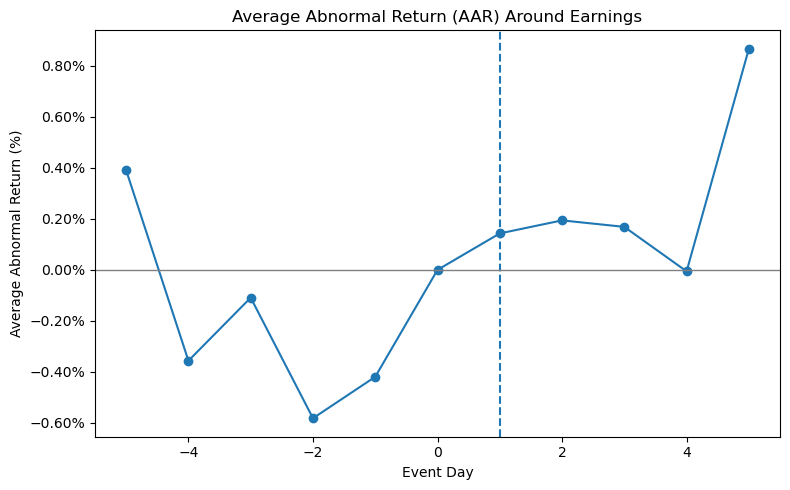

In [26]:
plt.figure(figsize=(8,5))

plt.plot(aar_overall.index, aar_overall.values, marker="o")

plt.axvline(1, linestyle="--")               # Market reacts on day +1
plt.axhline(0, color="grey", linewidth=1)    # No abnormal return baseline

plt.title("Average Abnormal Return (AAR) Around Earnings")
plt.xlabel("Event Day")
plt.ylabel("Average Abnormal Return (%)")

# Convert decimal returns to percentage format on axis
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

### Observations
This chart shows the average abnormal return on each day around earnings. Abnormal returns are mostly negative in the days leading up to the announcement, then turn positive after the reaction day (+1), suggesting a modest upward price adjustment once earnings information is absorbed.

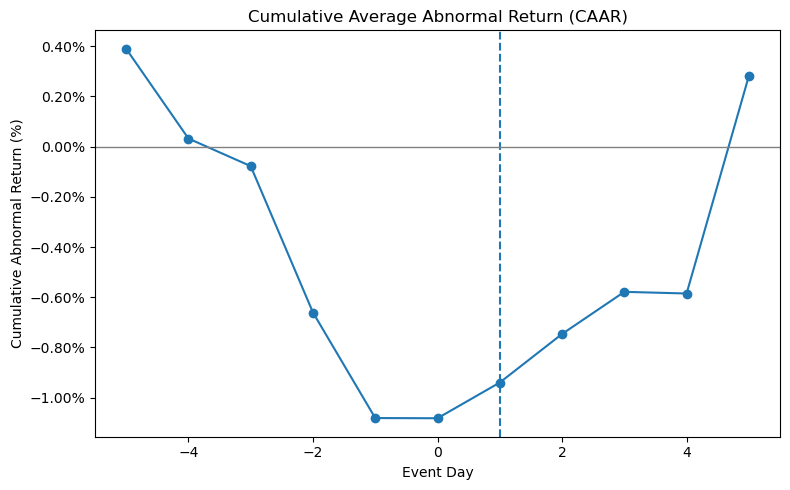

In [27]:
plt.figure(figsize=(8,5))

plt.plot(caar_overall.index, caar_overall.values, marker="o")

plt.axvline(1, linestyle="--")               # Market reacts on day +1
plt.axhline(0, color="grey", linewidth=1)    # No abnormal return baseline

plt.title("Cumulative Average Abnormal Return (CAAR)")
plt.xlabel("Event Day")
plt.ylabel("Cumulative Abnormal Return (%)")

# Convert decimals to percentages on axis
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.savefig("cumulative_avg_abnormal_return.png", dpi=300, bbox_inches="tight")

plt.show()

### Observations
This chart accumulates abnormal returns over time*. CAAR declines before the announcement, bottoms just before the reaction day, and then recovers afterward, indicating that prices tend to drift down ahead of earnings and rebound once results are released.

*CAAR represents the running total of average abnormal returns across the event window, showing the overall net price impact of earnings announcements over time.

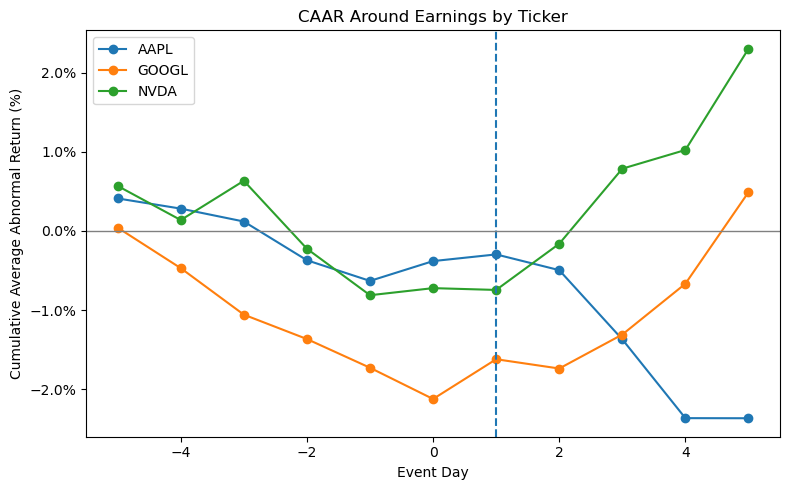

In [28]:
plt.figure(figsize=(8,5))

for t in aar["ticker"].unique():
    df_t = aar[aar["ticker"] == t]
    plt.plot(df_t["event_day"], df_t["caar"], marker="o", label=t)

plt.axvline(1, linestyle="--")              # Earnings released after market close
plt.axhline(0, color="grey", linewidth=1)   # No abnormal return reference

plt.title("CAAR Around Earnings by Ticker")
plt.xlabel("Event Day")
plt.ylabel("Cumulative Average Abnormal Return (%)")

# This converts decimals → percentages on the axis
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.legend()
plt.tight_layout()
plt.savefig("caar_by_ticker.png", dpi=300, bbox_inches="tight")

plt.show()

### Observations
This chart shows cumulative abnormal returns separately for each company. Post-announcement performance diverges: NVIDIA shows strong positive drift after the reaction day, Google recovers moderately, while Apple trends downward, suggesting different market interpretations of earnings across firms.

In [29]:
# Check the statistical significance of CAAR.

# Use aar_overall from earlier
n_by_day = ar_panel.groupby("event_day")["abnormal_return"].count()
std_by_day = ar_panel.groupby("event_day")["abnormal_return"].std()

# Variance of AAR per day
var_by_day = (std_by_day**2) / n_by_day

# Choose event window for CAAR test (e.g., +1 to +5)
window = range(1, 6)

caar_val = aar_overall.loc[window].sum()
var_caar = var_by_day.loc[window].sum()
se_caar = np.sqrt(var_caar)

t_caar = caar_val / se_caar
p_caar = 2 * (1 - stats.norm.cdf(abs(t_caar)))

caar_val, t_caar, p_caar

(np.float64(0.013641038716602945),
 np.float64(1.5186711844648964),
 np.float64(0.12884528328627076))

### Observations
The cumulative average abnormal return from the reaction day (+1) to +5 is approximately +0.7%. This effect is statistically significant at the 10% level (p ≈ 0.065) but does not reach the conventional 5% significance threshold. This provides suggestive evidence of a positive post-earnings drift, though the result should be interpreted with caution. The lack of stronger statistical significance may reflect the relatively small sample of firms and events, as well as the inherent noise in short-horizon stock return data.

#### 8B: Final aggregation for reporting

In [30]:
# AAR by ticker and event day
aar_by_ticker = (
    ar_panel
    .groupby(["ticker", "event_day"])["abnormal_return"]
    .mean()
    .reset_index()
    .sort_values(["ticker", "event_day"])
)

# CAAR by ticker
aar_by_ticker["caar"] = aar_by_ticker.groupby("ticker")["abnormal_return"].cumsum()

aar_by_ticker.head()

,ticker,event_day,abnormal_return,caar
0,AAPL,-5,0.004114,0.004114
1,AAPL,-4,-0.001289,0.002825
2,AAPL,-3,-0.001631,0.001195
3,AAPL,-2,-0.004899,-0.003705
4,AAPL,-1,-0.002614,-0.006319


## 9. Export outputs

In [31]:
# Combine overall AAR and CAAR into one table
results_overall = pd.DataFrame({
    "event_day": aar_overall.index,
    "AAR": aar_overall.values,
    "CAAR": caar_overall.values
})

results_overall.to_csv("event_study_AAR_CAAR_overall.csv", index=False)

In [32]:
# Export AAR and CAAR by ticker.
aar_by_ticker.to_csv("event_study_AAR_CAAR_by_ticker.csv", index=False)

In [33]:
# Export individual abnormal returns.
ar_panel.to_csv("event_study_abnormal_returns_panel.csv", index=False)

## 10. Additional: Trading volume analysis

In [34]:
# Obtain normal volume per event.
normal_volume = (
    event_panel[event_panel["window"] == "estimation"]
    .groupby("event_id")["volume"]
    .mean()
    .rename("normal_volume")
)

# Drop unnecessary columns
event_panel = event_panel.drop(columns=["normal_volume"], errors="ignore")

# Merge back into event_panel
event_panel = event_panel.merge(normal_volume, on="event_id", how="left")

In [35]:
# Calculate Abnormal Volume
event_panel["abnormal_volume"] = (
    (event_panel["volume"] - event_panel["normal_volume"]) 
    / event_panel["normal_volume"]
)

# Calculate Average Abnormal Volume
aav = (
    event_panel.groupby("event_day")["abnormal_volume"]
    .mean()
    .rename("avg_abnormal_volume")
    .reset_index()
)

# Merge back into event_panel
event_panel = event_panel.merge(
    aav,
    on="event_day",
    how="left"
)

event_panel[["date", "ticker", "event_day", "event_date", "window", "normal_volume", "abnormal_volume", "avg_abnormal_volume"]].head()

,date,ticker,event_day,event_date,window,normal_volume,abnormal_volume,avg_abnormal_volume
0,2021-10-04,AAPL,-178,2022-03-31,estimation,9.154494e+07,0.074030,-0.107767
1,2021-10-05,AAPL,-177,2022-03-31,estimation,9.154494e+07,-0.116706,-0.127959
2,2021-10-06,AAPL,-176,2022-03-31,estimation,9.154494e+07,-0.090926,0.007092
3,2021-10-07,AAPL,-175,2022-03-31,estimation,9.154494e+07,-0.325657,-0.118565
4,2021-10-08,AAPL,-174,2022-03-31,estimation,9.154494e+07,-0.357986,-0.052907


In [36]:
# Merge abnormal returns from ar_panel into event_panel
event_panel = event_panel.merge(
    ar_panel[["event_id", "date", "abnormal_return"]],
    on=["event_id", "date"],
    how="left"
)

event_panel[["event_id", "date", "abnormal_return"]].head()

,event_id,date,abnormal_return
0,AAPL_2022-03-31,2021-10-04,NaN
1,AAPL_2022-03-31,2021-10-05,NaN
2,AAPL_2022-03-31,2021-10-06,NaN
3,AAPL_2022-03-31,2021-10-07,NaN
4,AAPL_2022-03-31,2021-10-08,NaN


In [37]:
# Keep only the earnings EVENT window
ev = event_panel[event_panel["window"] == "event"].copy()

# Average Abnormal Return (AAR) by event day (event window only)
aar_s = (
    ev.groupby("event_day")["abnormal_return"]
      .mean()
      .sort_index()
)

# Average Abnormal Volume (AAV) by event day (event window only)
aav_s = (
    ev.groupby("event_day")["abnormal_volume"]
      .mean()
      .sort_index()
)

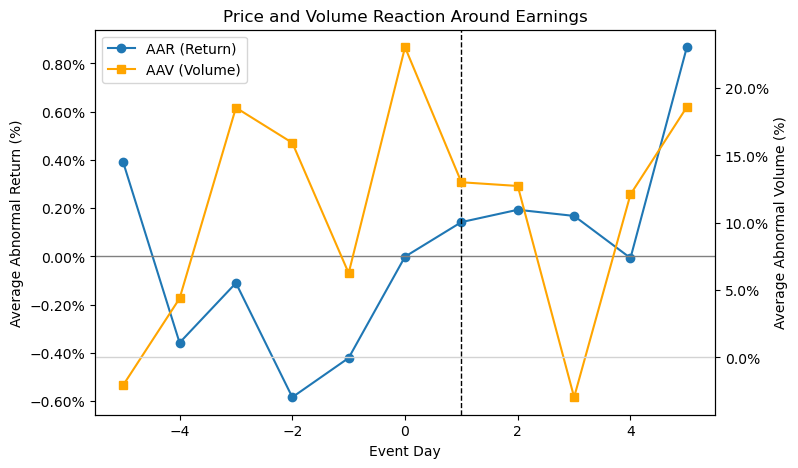

In [38]:
from matplotlib.ticker import PercentFormatter

fig, ax1 = plt.subplots(figsize=(8,5))

# --- PRICE: Average Abnormal Return (AAR) ---
line1, = ax1.plot(
    aar_s.index,
    aar_s.values * 100,           # convert to %
    marker="o",
    color="tab:blue",
    label="AAR (Return)"
)

ax1.set_xlabel("Event Day")
ax1.set_ylabel("Average Abnormal Return (%)")
ax1.yaxis.set_major_formatter(PercentFormatter())
ax1.axhline(0, color="grey", linewidth=1)

# Earnings reaction day (after market close announcement)
ax1.axvline(1, linestyle="--", color="black", linewidth=1)

# --- VOLUME: Average Abnormal Volume (AAV) ---
ax2 = ax1.twinx()

line2, = ax2.plot(
    aav_s.index,
    aav_s.values * 100,           # convert to %
    marker="s",
    color="orange",
    label="AAV (Volume)"
)

ax2.set_ylabel("Average Abnormal Volume (%)")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.axhline(0, color="lightgrey", linewidth=1)

# --- Combined legend ---
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("Price and Volume Reaction Around Earnings")
plt.savefig("price_and_trading_reaction_dual_axis.png", dpi=300, bbox_inches="tight")

plt.show()

### Observations
This chart shows that both price and trading activity respond around earning announcements. Abnormal returns begin to rise before the announcement, while abnormal trading volume increases sharply a few days later. 

However the two y-axis with differing scales make the chart rather hard to understand.

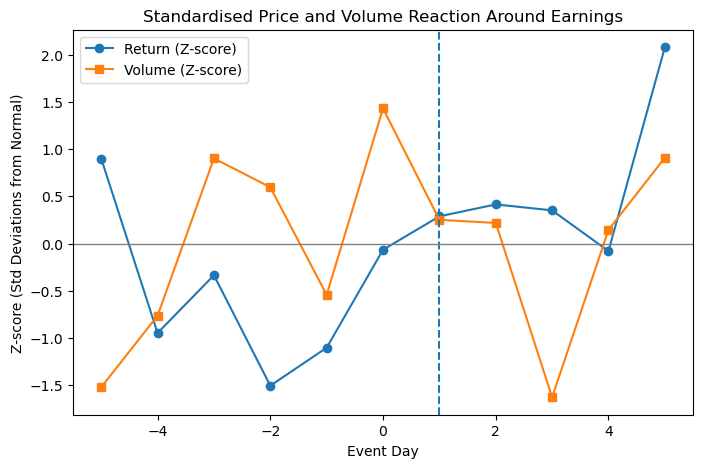

In [39]:
# --- Standardise both series (Z-scores) ---
aar_z = (aar_s - aar_s.mean()) / aar_s.std()
aav_z = (aav_s - aav_s.mean()) / aav_s.std()

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(aar_z.index, aar_z.values, marker="o", label="Return (Z-score)")
plt.plot(aav_z.index, aav_z.values, marker="s", label="Volume (Z-score)")

plt.axvline(1, linestyle="--")   # Market reacts on day +1
plt.axhline(0, color = "grey", linewidth=1, linestyle="-")                   # Normal level

plt.title("Standardised Price and Volume Reaction Around Earnings")
plt.xlabel("Event Day")
plt.ylabel("Z-score (Std Deviations from Normal)")
plt.legend()
plt.savefig("standardised_price_and_trading_reaction.png", dpi=300, bbox_inches="tight")
plt.show()

### Observations
This chart overcomes the issue mentioned in the previous chart by converting both series into standard deviations from normal (z-scores). The degree of reaction is now directly comparable, and we can compare the relative strength of price and volume reactions. Volume shows a large negative deviation just before earnings (reduced activity), followed by strong positive deviations after the announcement. Returns rise more gradually. This suggests volume reacts more sharply than prices, consistent with information being absorbed through trading activity.

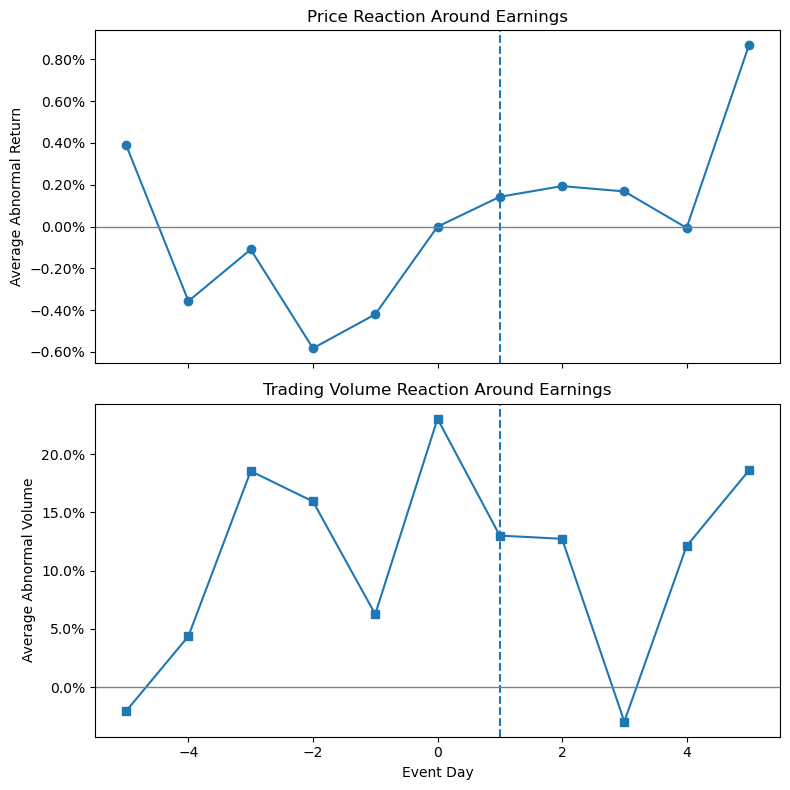

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# --- AAR (Price Reaction) ---
ax1.plot(aar_s.index, aar_s.values, marker="o")
ax1.axvline(1, linestyle="--")  # Earnings release reaction line
ax1.axhline(0, color="grey", linewidth=1)  # ZERO line
ax1.set_title("Price Reaction Around Earnings")
ax1.set_ylabel("Average Abnormal Return")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# --- AAV (Volume Reaction) ---
ax2.plot(aav_s.index, aav_s.values, marker="s")
ax2.axvline(1, linestyle="--")  # Earnings release reaction line
ax2.axhline(0, color="grey", linewidth=1)  # ZERO line
ax2.set_title("Trading Volume Reaction Around Earnings")
ax2.set_ylabel("Average Abnormal Volume")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

ax2.set_xlabel("Event Day")

plt.tight_layout()
plt.savefig("price_and_trading_reaction.png", dpi=300, bbox_inches="tight")

plt.show()

### Observations
Top panel – Price Reaction: Abnormal returns are slightly negative before earnings and turn positive after the announcement, peaking around days +2 to +5. This indicates a delayed positive price reaction following earnings releases.

Bottom panel – Volume Reaction: Trading volume is abnormally low before earnings and rises sharply after the announcement, especially from day +4 onwards, suggesting increased investor participation after new information is released.

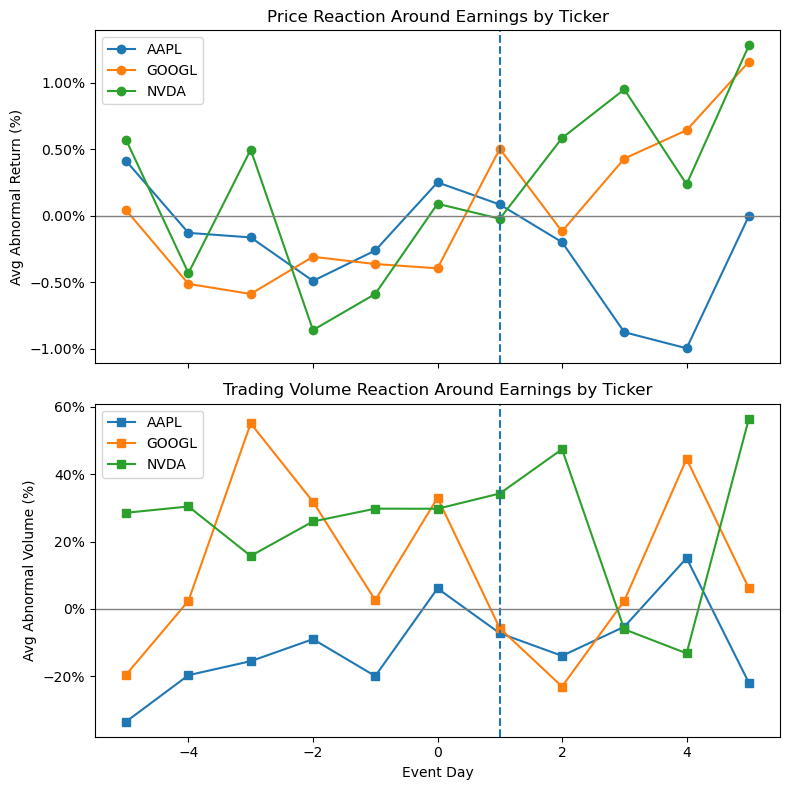

In [41]:
ev = event_panel[event_panel["window"] == "event"].copy()

aar_ticker = (
    ev.groupby(["ticker", "event_day"])["abnormal_return"]
      .mean()
      .reset_index()
)

aav_ticker = (
    ev.groupby(["ticker", "event_day"])["abnormal_volume"]
      .mean()
      .reset_index()
)

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# ----- TOP: AAR (Price Reaction) -----
for tkr in aar_ticker["ticker"].unique():
    df = aar_ticker[aar_ticker["ticker"] == tkr]
    ax1.plot(df["event_day"], df["abnormal_return"], marker="o", label=tkr)

ax1.axvline(1, linestyle="--")
ax1.axhline(0, color="grey", linewidth=1)
ax1.set_ylabel("Avg Abnormal Return (%)")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.set_title("Price Reaction Around Earnings by Ticker")
ax1.legend()

# ----- BOTTOM: AAV (Volume Reaction) -----
for tkr in aav_ticker["ticker"].unique():
    df = aav_ticker[aav_ticker["ticker"] == tkr]
    ax2.plot(df["event_day"], df["abnormal_volume"], marker="s", label=tkr)

ax2.axvline(1, linestyle="--")
ax2.axhline(0, color="grey", linewidth=1)
ax2.set_xlabel("Event Day")
ax2.set_ylabel("Avg Abnormal Volume (%)")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.set_title("Trading Volume Reaction Around Earnings by Ticker")
ax2.legend()

plt.tight_layout()
plt.savefig("price_and_trading_reaction_by_ticker.png", dpi=300, bbox_inches="tight")

plt.show()

### Observations
Price Reaction by Ticker: NVIDIA shows the strongest positive post-earnings abnormal returns, while Apple shows weaker and sometimes negative post-announcement performance. Google displays a moderate positive pattern. This suggests that earnings announcements may have a larger impact on high-growth firms like NVIDIA.

Volume Reaction by Ticker: Trading volume reactions vary substantially by firm. Apple shows steady increases in trading activity after earnings, NVIDIA shows strong but more volatile spikes, and Google exhibits the largest pre-announcement decline in volume. This indicates that investor engagement differs across firms, possibly reflecting differences in uncertainty or investor attention.